In [1]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import copy
import os

if not os.path.exists('figures'):
   os.makedirs('figures')

sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

full_df = pd.read_csv('data/roft.csv')
full_df["date"] = pd.to_datetime(full_df["date"])

In [19]:
full_df.columns

Index(['date', 'model', 'dataset', 'annotator', 'group', 'dec_strat_value',
       'predicted_boundary_index', 'true_boundary_index', 'points', 'reason',
       'prompt', 'prompt_body', 'generation', 'gen_body', 'recipe_familiarity',
       'news_familiarity', 'stories_familiarity', 'gen_familiarity',
       'native_speaker', 'read_guide'],
      dtype='object')

In [2]:
full_df['model'].value_counts()

gpt2-xl          7037
finetuned        5245
davinci          4991
human            3397
ctrl-Politics    2628
gpt2             2485
ctrl-nocode      1635
baseline          196
Name: model, dtype: int64

In [3]:
full_df['group'].value_counts()

B    14326
C     7290
A     5998
Name: group, dtype: int64

In [4]:
full_df['dataset'].value_counts()

Recipes                  9827
Short Stories            7607
New York Times           5334
Presidential Speeches    4846
Name: dataset, dtype: int64

In [5]:
full_df_gpt3 = full_df[full_df['group'] == 'C']
full_df = full_df[full_df['group'] != 'C']

In [6]:
full_df

,date,model,dataset,annotator,group,dec_strat_value,predicted_boundary_index,true_boundary_index,points,reason,prompt,prompt_body,generation,gen_body,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,native_speaker,read_guide
0,2021-08-31 17:11:39.095000+00:00,finetuned,Recipes,1666,A,0.4,0,2,0,['9123971792800820313'],13803,HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,22877,"Meanwhile, combine all dressing ingredients in...",2,3,5,2,Yes,NaN
1,2021-09-06 21:54:48.912000+00:00,finetuned,Recipes,1666,A,0.4,8,8,5,['irrelevant'],20719,HOW TO MAKE: Nest Cookies\nIngredients:\n1 12 ...,26444,Photograph by fans blistering bens down!_SEP_F...,2,3,5,2,Yes,NaN
2,2021-09-06 21:55:07.069000+00:00,finetuned,Recipes,1666,A,0.4,0,7,0,['irrelevant'],20365,HOW TO MAKE: Pink Lemonade Cupcakes\nIngredien...,26089,Fill prepared pans two-thirds full._SEP_Bake f...,2,3,5,2,Yes,NaN
3,2021-09-06 21:58:44.944000+00:00,finetuned,Recipes,1666,A,0.4,1,7,0,['326860638652886185'],20240,HOW TO MAKE: Beef Stroganaff\nIngredients:\n1 ...,25963,"I have added some green peppers, red peppers, ...",2,3,5,2,Yes,NaN
4,2021-09-06 21:59:16.230000+00:00,finetuned,Recipes,1666,A,0.4,1,2,0,['repetition'],13888,HOW TO MAKE: One-Pan Creamy Chicken and Veggie...,23225,Add frozen veggies and pasta._SEP_Pour in chic...,2,3,5,2,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20319,2022-06-02 01:26:18.887000+00:00,gpt2,Short Stories,14286,B,0.4,8,4,1,"['common_sense', 'grammar']",3587,Alois looked up from his tea and noticed a sha...,3539,The boy began walking slowly toward him as he ...,3,2,2,2,Yes,Yes
20320,2022-06-02 01:27:43.635000+00:00,gpt2,Short Stories,14286,B,0.4,0,3,0,['grammar'],3403,"""Another child found dead in his bed last nigh...",3357,He walks into town and greets some friends who...,3,2,2,2,Yes,Yes
20321,2022-06-02 01:28:39.403000+00:00,gpt2,Short Stories,14286,B,0.4,7,3,1,['irrelevant'],3482,**The Curious Case of the Duck in the Nighttim...,3435,It doesn't help if your eyes hurt or go red wh...,3,2,2,2,Yes,Yes
20322,2022-06-02 01:30:02.484000+00:00,gpt2,Short Stories,14286,B,0.4,5,5,5,['contradicts_sentence'],4010,I'd finally bagged that big elk i've been stal...,3957,As soon as we got there on foot or by car (_SE...,3,2,2,2,Yes,Yes


In [7]:
def find_frequent_annotators(df, min_n=10):
  """Retrieve a list of annotators who have done a minimum number of annotations."""
  return [a for a in set(df["annotator"].tolist()) if len(df[df["annotator"] == a]["points"].tolist()) >= min_n]

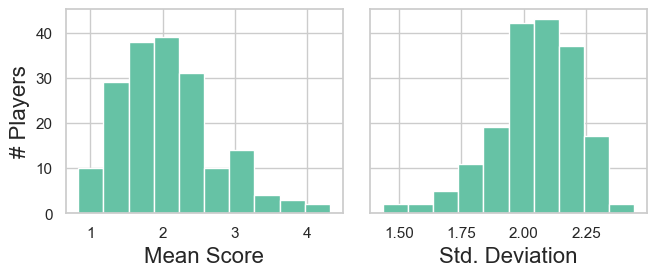

Std. dev for score over 3.8 1.8458925514752458


In [8]:
freq20_annotators = find_frequent_annotators(full_df, 20)
full_df_freq20 = full_df[full_df["annotator"].isin(freq20_annotators)]

df_meanscore=full_df_freq20.groupby(["annotator"]).points.mean().reset_index()
df_meanscore.rename({"points": "Mean Score"}, axis=1, inplace=True)
df_stdscore=full_df_freq20.groupby(["annotator"]).points.std().reset_index()
df_stdscore.rename({"points": "Standard Deviation"}, axis=1, inplace=True)
df_scores = pd.merge(df_meanscore, df_stdscore, on="annotator")

fig = plt.figure(figsize=[7.5, 3])
axes = fig.subplots(1, 2, sharey=True)
df_scores.hist(column=["Mean Score", "Standard Deviation"], ax=axes)
axes[0].set(title='')
axes[1].set(title='')
axes[0].set_ylabel("# Players", fontsize = 16)
axes[0].set_xlabel("Mean Score", fontsize = 16)
axes[1].set_xlabel("Std. Deviation", fontsize = 16)
axes[1].xaxis.set_ticks(np.arange(1.5, 2.5, 0.25))

plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(bottom=0.2)
plt.savefig("figures/mean_variance.pdf")
plt.show()

print("Std. dev for score over 3.8 " + str(df_scores[df_scores["Mean Score"] > 3.8]["Standard Deviation"].mean()))

In [9]:
full_df[(full_df['date'] > '2021-10-1') & (full_df['group']=='A')]

,date,model,dataset,annotator,group,dec_strat_value,predicted_boundary_index,true_boundary_index,points,reason,prompt,prompt_body,generation,gen_body,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,native_speaker,read_guide


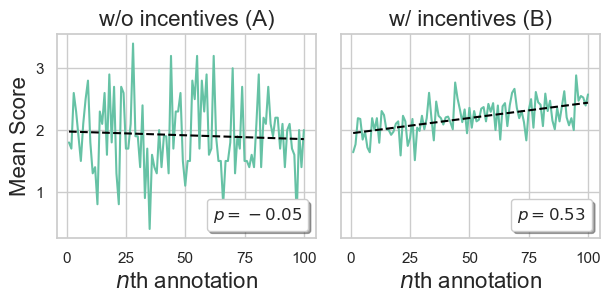

In [10]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = find_frequent_annotators(df, k)
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"].iloc[:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[7, 3])
axes = fig.subplots(1, 2, sharey=True)

s1, n1 = analyze_progress(full_df[full_df['group']=='A'], 100)
s2, n2 = analyze_progress(full_df[full_df['group']=='B'], 100)

a, b = np.polyfit(range(1, 100+1), np.mean(np.array(s1), axis=0), 1)
spearman = scipy.stats.spearmanr(range(1, 100+1), np.mean(np.array(s1), axis=0))
axes[0].plot(range(1, 100+1), np.mean(np.array(s1), axis=0))
axes[0].plot(range(1, 100+1), a*range(1, 100+1)+b, color='black', linestyle='--')
axes[0].legend([], loc="lower right", title="$p={:10.2f}$".format(spearman[0]), shadow=True, labelspacing=0)

a, b = np.polyfit(range(1, 100+1), np.mean(np.array(s2), axis=0), 1)
spearman = scipy.stats.spearmanr(range(1, 100+1), np.mean(np.array(s2), axis=0))
axes[1].plot(range(1, 100+1), np.mean(np.array(s2), axis=0))
axes[1].plot(range(1, 100+1), a*range(1, 100+1)+b, color='black', linestyle='--')
axes[1].legend([], loc="lower right", title="$p={:10.2f}$".format(spearman[0]), shadow=True, labelspacing=0)
axes[0].set_title("w/o incentives (A)", fontsize = 16)
axes[0].set_xlabel("$n$th annotation", fontsize = 16)
axes[0].set_ylabel("Mean Score", fontsize = 16)
axes[1].set_title("w/ incentives (B)",  fontsize = 16)
axes[1].set_xlabel("$n$th annotation", fontsize = 16)
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(bottom=0.2)
plt.savefig("figures/overtime.pdf")
plt.show()

In [11]:
def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def map_p_value(x):
  "Converts float p values to the naames we want to use in the paper."""
  if x >= 0:
    return "$p={}$".format(x)
  else:
    return "sanity"

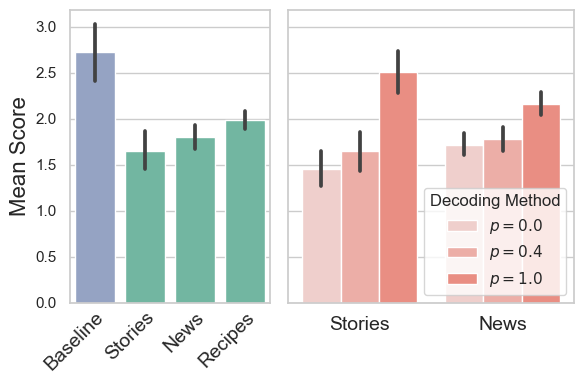

In [12]:
figure = plt.figure(figsize=[6, 4], tight_layout=True)
axes = figure.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [0.7, 1]})
matplotlib.rc('xtick', labelsize=12) 

filtered_df = full_df[((full_df["model"]=="gpt2-xl") & (full_df["dec_strat_value"]==0.4)) | (full_df["model"]=="baseline")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dataset"] = filtered_df.apply(lambda x: "Baseline" if x["model"] == "baseline" else x["dataset"], axis=1)

palette1 = [sns.color_palette("Set2")[2]] + [sns.color_palette("Set2")[0]]*3
order = ["Baseline", "Stories", "News", "Recipes"]
ax = sns.barplot(x="dataset", y="points", data=filtered_df, order=order, ax=axes[0], palette=palette1)
ax.set_title("")
ax.set_xlabel("")
ax.tick_params(axis='x', which='major', pad=-2)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Mean Score", fontsize = 16)

palette = sns.light_palette("Salmon", n_colors=4)[1:4] + [sns.color_palette("Set2")[2]]

filtered_df = full_df[(full_df["model"]=="gpt2-xl") & (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)

order = ["$p=0.0$","$p=0.4$","$p=1.0$"]
ax = sns.barplot(x="dataset", y="points", hue="dec_strat_value", order=["Stories", "News"], data=filtered_df, hue_order=order, ax=axes[1], palette=palette)
ax.set_xlabel("", fontsize = 16)
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.legend(loc="lower right", ncol=1).set_title("Decoding Method")
plt.tight_layout()
plt.savefig("figures/domain_topp.pdf", dpi=1000)

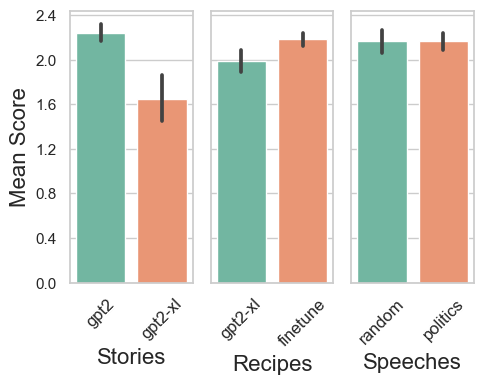

In [13]:
fig = plt.figure(figsize=[5, 4])
axes = fig.subplots(1, 3, sharey=True)
matplotlib.rc('xtick', labelsize=14) 



filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'gpt2' if x == 'gpt2' else x)
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories", fontsize=16)
p.set_ylabel("Mean Score", fontsize=16)
p.set_yticks(np.arange(0, 2.6, 0.4))
p.set_xticklabels(p.get_xticklabels(), rotation=45)
                  
filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1], order=["gpt2-xl", "finetune"])
p.set_title("")
p.set_xlabel("Recipes", fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'random' if x == 'ctrl-nocode' else 'politics')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches", fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=45)

p.set_ylabel("")

plt.tight_layout()
plt.savefig("figures/model_size_and_finetuning.pdf")
plt.show()

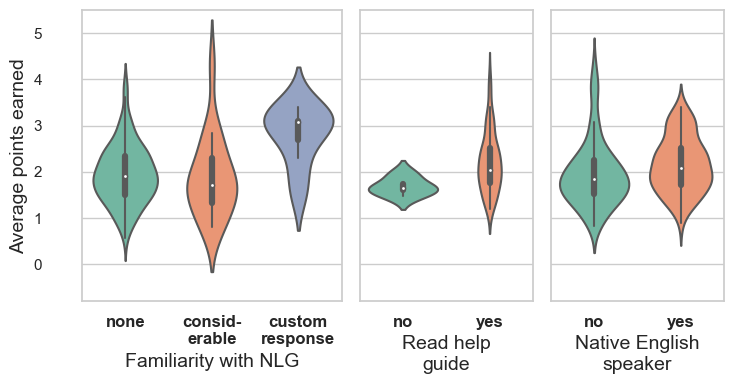

In [14]:
SHOW_FAMILIARTIES = False

if SHOW_FAMILIARTIES:
  fig = plt.figure(figsize=[15, 4])
  fig.tight_layout(pad=0)
  width_ratios = [0.1, 3, 2, 2, 2, 2, 2]
  axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})
else:
  fig = plt.figure(figsize=[7.5, 4])
  fig.tight_layout(pad=0)
  width_ratios = [0.1, 3, 2, 2]
  axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})

ax = axes[0]
ax.set_ylim([-0.8, 5.5])
ax.set_ylabel("Average points earned", fontsize=14)
ax.grid(visible=False)
ax.xaxis.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.subplots_adjust(wspace=0)

# Familiarity
order = collections.OrderedDict([(1, "none"), (4, "consid-\nerable"), (-1, "custom\nresponse")])
full_df_freq10 = full_df[full_df['annotator'].isin(find_frequent_annotators(full_df, 10))]
df=full_df_freq10.groupby(["annotator", "gen_familiarity"]).points.mean().reset_index()
df = df[(df["gen_familiarity"] == -1) | (df["gen_familiarity"] == 1) | (df["gen_familiarity"] == 4)]
df["gen_familiarity"] = df["gen_familiarity"].apply(lambda x: order[x])
ax = sns.violinplot(x="gen_familiarity", y="points", data=df, order=order.values(), ax=axes[1])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold', rotation=0)
ax.set_ylabel("")
ax.set_xlabel("Familiarity with NLG", fontsize=14)

# Read guide
order = collections.OrderedDict([("No", "no"), ("Yes", "yes")])
df = full_df_freq20[full_df_freq20["read_guide"] != ""]
df=df.groupby(["annotator", "read_guide"]).points.mean().reset_index()
df["read_guide"] = df["read_guide"].apply(lambda x: order[x])
ax = sns.violinplot(x="read_guide", y="points", data=df, order=order.values(), ax=axes[2])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Read help\nguide", fontsize=14)

# Native English speaker
df = full_df_freq20[full_df_freq20["native_speaker"] != ""]
df=df.groupby(["annotator", "native_speaker"]).points.mean().reset_index()
ax = sns.violinplot(x="native_speaker", y="points", data=df, ax=axes[3])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Native English\nspeaker", fontsize=14)

if SHOW_FAMILIARTIES:
  # Recipe familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["recipe_familiarity"] == 1) | (full_df_freq20["recipe_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["annotator", "recipe_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="recipe_familiarity", y="points", data=df, ax=axes[4])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nrecipes", fontsize=14)

  # News familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["news_familiarity"] == 1) | (full_df_freq20["news_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["annotator", "news_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="news_familiarity", y="points", data=df, ax=axes[5])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nnews", fontsize=14)

  # Fiction familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["stories_familiarity"] == 1) | (full_df_freq20["stories_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["annotator", "stories_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="stories_familiarity", y="points", data=df, ax=axes[6])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nfiction", fontsize=14)
plt.tight_layout()
plt.savefig("figures/survey_results_no_fam.pdf")
plt.show()

In [15]:
def mean_confidence_interval_me(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    left, right = scipy.stats.norm.interval(confidence=confidence,loc=m, scale=se)
    return round(left - m, 5), round(right - m, 5)

In [16]:
REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def is_other(x):
  return len(x) != 2 and not any([r in x for r in REASONS])

reason_df = copy.deepcopy(full_df)
for r in REASONS:
  reason_df[r] = full_df['reason'].apply(lambda x: r in x)
reason_df["other"] = full_df['reason'].apply(is_other)

In [17]:
def analyze_per_reason():
  info_to_return = []
  for r in REASONS:
    df = reason_df[(reason_df[r]==True) & (reason_df["model"]!="baseline") & (reason_df["model"]!="human") & (reason_df["model"]!="davinci")]
    
    if len(df) > 0:
      info = {"reason": r,
              "mean score": np.mean(df["points"]),
              "95% conf": mean_confidence_interval_me(df["points"]),
              "num_annotations": len(df)
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason()

,reason,mean score,95% conf,num_annotations
0,grammar,1.765432,"(-0.10749, 0.10749)",1458
1,repetition,2.085758,"(-0.16101, 0.16101)",653
2,irrelevant,2.540729,"(-0.06747, 0.06747)",3867
3,contradicts_sentence,2.567024,"(-0.10886, 0.10886)",1492
4,contradicts_knowledge,2.295872,"(-0.11565, 0.11565)",1308
5,common_sense,2.570383,"(-0.08839, 0.08839)",2323
6,coreference,2.317172,"(-0.18587, 0.18587)",495
7,generic,1.966211,"(-0.10706, 0.10706)",1391
8,other,2.142857,"(-0.53194, 0.53194)",63


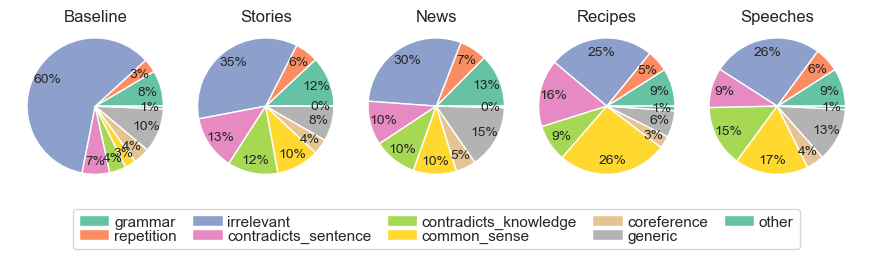

In [18]:
fig = plt.figure(figsize=[11, 3])
axes = fig.subplots(1, 5)

def plot_reasons_pie(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 10})
  ax.set_title(title, y=0.95, fontsize=12)
  return patches

plot_reasons_pie(reason_df[(reason_df['model']=='baseline')], axes[0], "Baseline")
patches = plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], axes[1], "Stories")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], axes[2], "News")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], axes[3], "Recipes")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='Presidential Speeches') & (reason_df['model']=='ctrl-nocode')], axes[4], "Speeches")

fig.legend(patches, REASONS, loc="lower center", ncol=5, labelspacing=0.0, handletextpad=0.3, columnspacing=1, prop={'size':11})
plt.subplots_adjust(wspace=0)
plt.savefig("figures/reasons_per_domain.pdf")